# BERT base neuralmind, soma dos score do par.

## Conceptnet-hypernym-all-relations
- (1,1) é um par onde hipônimo e hiperônimo são de tamanho 1
- O tamanho do par (1,1) será 2, assim como o tamanho do par (2,1) e (1,2) será 3

> Suponha o par (3,2) (abacate, fruta)
> Temos as seguintes sentenças:
- [MASK] ca te é um tipo de fru ta
- aba [MASK] te é um tipo de fru ta
- aba ca [MASK] é um tipo de fru ta
- aba ca te é um tipo de [MASK] ta
- aba ca te é um tipo de fru [MASK]

> Mascarando a palavra e pegando o score dela. O score pra esse par será a soma de todos os valores recuperados.


In [2]:
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import torch
import os
import nb_utils

sns.set(style="whitegrid")
plt.clf()
method_names = {'word2vec': 'Word2vec C', 'summation_dot_product': 'DIVE \u0394S * C ', 'dot_product': 'DIVE C',
                'rnd': 'random', 'summation': 'DIVE \u0394S', 'summation_word2vec': 'DIVE \u0394S * Word2vec C',
                'all_subword mean_positional_rank': 'BERT Mean Pos Rank', 'all_subword min_positional_rank': 'BERT Min Pos Rank',
                'all_subword max_pattern': 'BERT Max Pattern', 'all_subword mean_pattern': 'BERT Mean Pattern',
                'min score_final_log(z)': 'BERT Min Pos Rank (log(z))', 'min score_final_norm': 'BERT Min Pos Rank (/ norm)',
                'mean score_final_log(z)': 'BERT Mean Pos Rank (log(z))', 'mean score_final_norm': 'BERT Mean Pos Rank (/ norm)'}

# data
# path_file_bert = "../aaaaaaaa/test_neuralmind-bert-base-portuguese-cased/TESTE.json"
path_file_bert = "../teste/neuralmind-bert-base-portuguese-cased_bert-score_n-subtoken/conceptnet-hypernym-allrelation.json"

f_in = open(path_file_bert)
json_data = json.load(f_in)

vocabs = ["../vocabs/wikipedia15M/vocab.txt",
          "../vocabs/wikipedia30M/vocab.txt",
          "../vocabs/wikipedia60M/vocab.txt",
          "../vocabs/wikipedia120M/vocab.txt",
          "../vocabs/wikipedia240M/vocab.txt"]
path_d_w = ["/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_not_oov/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv",
            "/home/gabrielescobar/Documentos/dive-pytorch/results/wikipedia-datasets-test/wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX/_result_models_model-wikipedia240M_W10_neg15_e15_lr1e-03_eps1e-08_emb100_batch128_runX_dataset_.-datasets.tsv"]
df_dive_word2vec = pd.read_csv(path_d_w[0], delimiter="\t")
df_dive_word2vec = df_dive_word2vec[df_dive_word2vec['epoch_num'] == 14]
# df_15 = create_dataframe(filter_by_vocab(vocabs[0], json_data))
# df_30 = create_dataframe(filter_by_vocab(vocabs[1], json_data))
# df_60 = create_dataframe(filter_by_vocab(vocabs[2], json_data))
# df_120 = create_dataframe(filter_by_vocab(vocabs[3], json_data))
df_240 = nb_utils.create_dataframe(nb_utils.filter_by_vocab(vocabs[4], json_data))
df_with_oov = nb_utils.create_dataframe(json_data)


pattern_unique = df_with_oov['pattern'].unique().tolist()
len_total_unique = df_with_oov['len_total'].unique().tolist()

# print(f"DF 15 = {df_15[df_15['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 30 = {df_30[df_30['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 60 = {df_60[df_60['pattern'] == pattern_unique[0]].count()['hiponimo']}")
# print(f"DF 120 = {df_120[df_120['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF 240 = {df_240[df_240['pattern'] == pattern_unique[0]].count()['hiponimo']}")
print(f"DF all with OOV = {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]].count()['hiponimo']}")

df_taxa = nb_utils.balanceamento(df_with_oov, len_size=len_total_unique, patterns=pattern_unique)

df_with_oov = nb_utils.logsumexp_normalization(df_with_oov, len_list=len_total_unique, pattern_list=pattern_unique)


DF 240 = 14330
DF all with OOV = 30474


<Figure size 432x288 with 0 Axes>

### AP para cada pattern
- Existem 2 score final
 > Soma BERT - log(Z), sendo log(Z) o logsumexp das somas do BERT para um determinado tamanho de subtoken e padrão.

 > Soma BERT / Soma de todos os BERT, este ultimo usando somente os BERT de mesmo tamanho de subtoken e padrao.

In [3]:
# # AP por pattern com oov
# # ap usando bert_sum - log(Z)
#
# df_ap = compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_log(z)", pattern_list=pattern_unique)
# plt.figure(figsize=(15,8))
# ax = sns.barplot(data=df_ap, x='padrao', y='AP')
# ax.set(xlabel="Padrão")
# ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT - log(Z)")
# plt.xticks(rotation=75)
# plt.show()
# print(f"Melhores padrões usando score_final_log(Z)")
# best_pattern_logz = df_ap.sort_values(by='AP', ascending=False)['padrao'].tolist()
# print(best_pattern_logz)

In [4]:
# # AP por pattern sem oov
# # ap usando bert_sum / sum(bert_sum_tokensize)
# df_view = df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]
#
# df_ap = compute_dataframe_AP_by_pattern(df_with_oov, key_sort="score_final_norm", pattern_list=pattern_unique)
# plt.figure(figsize=(15,8))
# ax = sns.barplot(data=df_ap, x='padrao', y='AP')
# ax.set(xlabel="Padrão")
# ax.set_title(f"BERT AP por padrão. Score final é a soma do BERT normalizado")
# plt.xticks(rotation=75)
# plt.show()
# print(f"Melhores padrões usando score_final_norm")
# best_pattern_norm = df_ap.sort_values(by='AP', ascending=False)['padrao'].tolist()
# print(best_pattern_norm)

## Comparando BERT com DIVE e Word2Vec SEM OOV

### Dataset conceptnet-1
- Usando Wikipedia240M
- N= 14330
- Usando 4 melhores padrões

DF 240 True= 1219
False= 13111
% True= 0.08506629448709002
Balanceamento: 13 não está no dataframe!
Balanceamento: 12 não está no dataframe!


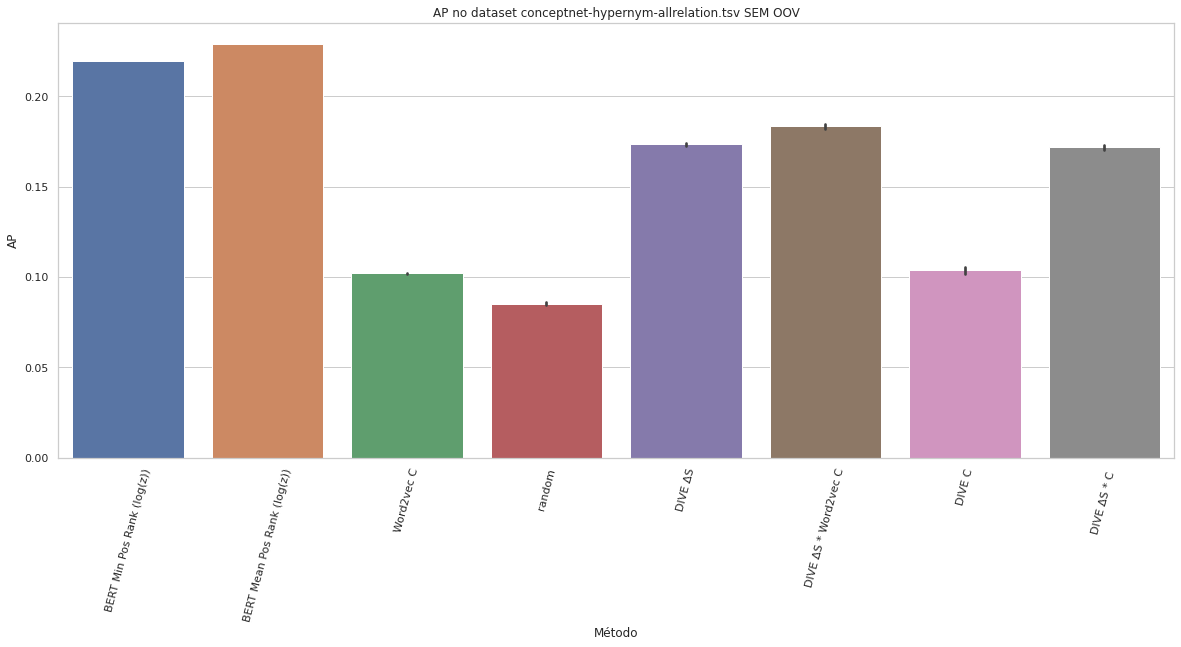

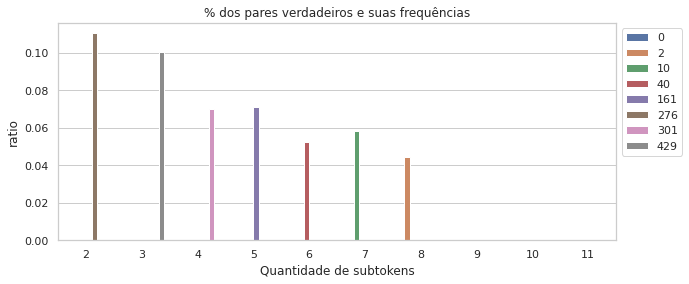

In [5]:
sns.set_theme(style="whitegrid")
best_pattern_without_oov = ['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']


df_240 = nb_utils.logsumexp_normalization(df_240, len_list=len_total_unique, pattern_list=pattern_unique)

print(f"DF 240 True= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']}\n"
      f"False= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['False']}\n"
      f"% True= {df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']/(df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['True'] + df_240[df_240['pattern'] == pattern_unique[0]]['classe'].value_counts()['False'])}")

dfs = []
dataset_name = path_file_bert.split("/")[-1][:-4] + "tsv"
method_score = ["score_final_log(z)", "score_final_norm"]
best_pattern_num = 4
for score_name in method_score[:1]:
    if score_name == "score_final_log(z)":
        min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_240, key_sort=score_name, best_patterns=best_pattern_without_oov[:best_pattern_num])
    elif score_name == "score_final_norm":
        min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_240, key_sort=score_name, best_patterns=best_pattern_without_oov[:best_pattern_num])
    n_pair = df_240.groupby('pattern').count().iloc[0]['hiponimo']
    hyper_num = df_240[df_240['pattern'] == pattern_unique[0]]['fonte'].value_counts()
    hyper_num = hyper_num['hyper']
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"min {score_name}", 'AP': [min_ap]})
    dfs.append(df)
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"mean {score_name}", 'AP': [mean_ap]})
    dfs.append(df)

df = pd.concat(dfs)

df_all = pd.concat([df, df_dive_word2vec])
df_all['method_format'] = df_all['method'].map(method_names)
datasetnames_unique = df_all['dataset'].unique().tolist()
rename_dataset = {}
for k in datasetnames_unique:
    rename_dataset[k] = os.path.basename(k)

df_all['dataset'] = df_all['dataset'].map(rename_dataset)

df_ratio = nb_utils.balanceamento(df_240, len_size=len_total_unique, patterns=pattern_unique)

# df dive-word2vec 240 sem OOV
df_plot = df_all[df_all['dataset'] == dataset_name]

plt.figure(figsize=(20,8))
ax = sns.barplot(x="method_format", y="AP", data=df_plot)
ax.set(xlabel="Método")
ax.set_title(f"AP no dataset {dataset_name} SEM OOV")
plt.xticks(rotation=75)

plt.figure(figsize=(10,4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")

ax.legend(bbox_to_anchor=(1, 1))


## Comparando BERT com DIVE e Word2Vec COM OOV

### Dataset conceptnet-all-relation
- Usando Wikipedia240M
- N= 30474
- Usando 4 melhores padrões

DF 240 True= 2323
False= 28151
% True= 0.07622891645337009


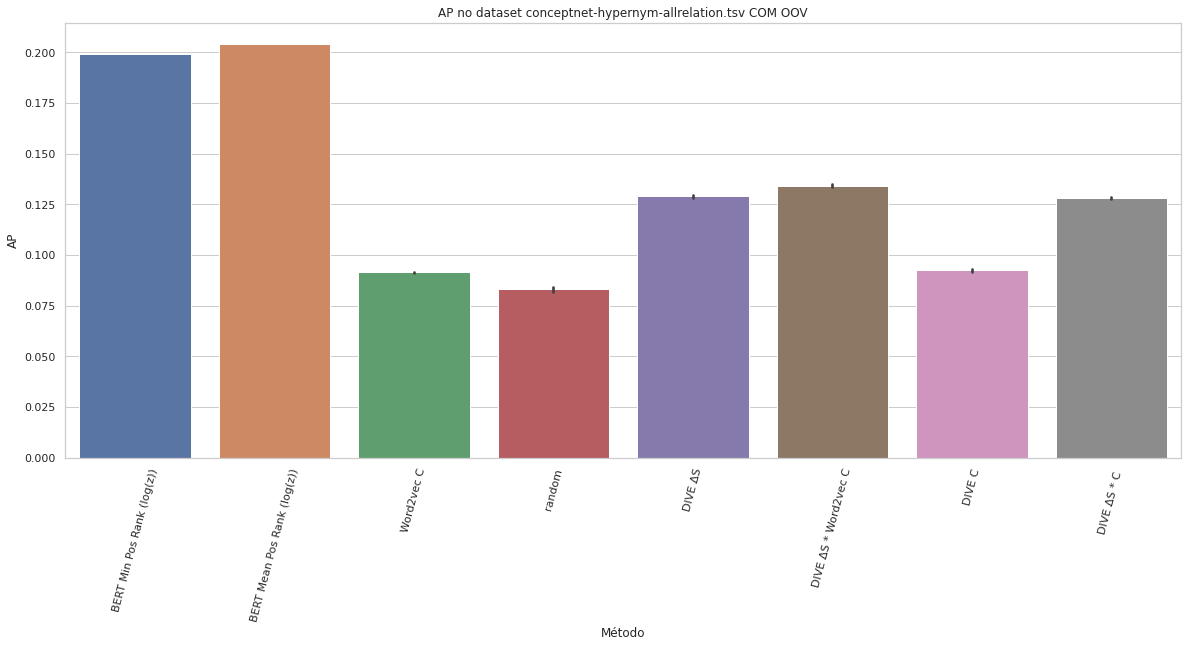

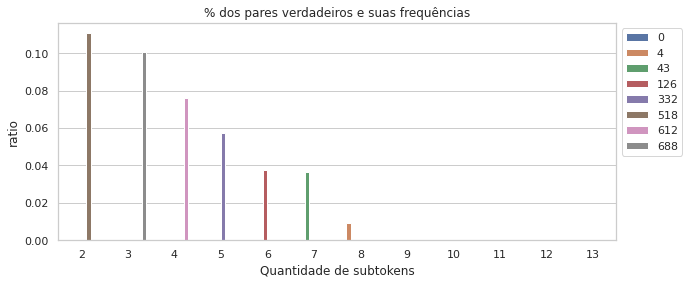

In [6]:
print(f"DF 240 True= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']}\n"
      f"False= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['False']}\n"
      f"% True= {df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True']/(df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['True'] + df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['classe'].value_counts()['False'])}")

# usar df_with_oov
best_pattern_with_oov = ['{} ou qualquer outro {}', '{} é um tipo de {}', '{} ou outro {}', '{} ou algum outro {}', '{} e outros {}', '{} e qualquer outro {}', '{} e algum outro {}', '{} , um {}', '{} incluindo {}', '{} é um {}', '{} é um caso especial de {}', '{} que é chamado de {}', '{} que é um tipo de {}', '{} que é um exemplo de {}', '{} que é uma classe de {}']

dfs = []
for score_name in method_score[:1]:
    if score_name == "score_final_log(z)":
        min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_with_oov, key_sort=score_name, best_patterns=best_pattern_with_oov[:best_pattern_num])
    elif score_name == "score_final_norm":
        min_ap, mean_ap = nb_utils.compute_AP_by_rank(df_with_oov, key_sort=score_name, best_patterns=best_pattern_with_oov[:best_pattern_num])
    n_pair = df_with_oov.groupby('pattern').count().iloc[0]['hiponimo']
    hyper_num = df_with_oov[df_with_oov['pattern'] == pattern_unique[0]]['fonte'].value_counts()
    hyper_num = hyper_num['hyper']
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"min {score_name}", 'AP': [min_ap]})
    dfs.append(df)
    df = pd.DataFrame({'dataset': [dataset_name], 'N': [n_pair], 'hyper_num': [hyper_num], 'method': f"mean {score_name}", 'AP': [mean_ap]})
    dfs.append(df)

df = pd.concat(dfs)

# df dive-word2vec com oov
df_dive_word2vec_all = pd.read_csv(path_d_w[1], delimiter="\t")
df_dive_word2vec_all = df_dive_word2vec_all[df_dive_word2vec_all['epoch_num'] == 14]
df_all = pd.concat([df, df_dive_word2vec_all])

df_all['method_format'] = df_all['method'].map(method_names)
datasetnames_unique = df_all['dataset'].unique().tolist()
rename_dataset = {}
for k in datasetnames_unique:
    rename_dataset[k] = os.path.basename(k)

df_all['dataset'] = df_all['dataset'].map(rename_dataset)
df_ratio = nb_utils.balanceamento(df_with_oov, len_size=len_total_unique, patterns=pattern_unique)

# df dive-word2vec 240 com OOV
df_plot = df_all[df_all['dataset'] == dataset_name]

plt.figure(figsize=(20,8))
ax = sns.barplot(x="method_format", y="AP", data=df_plot)
ax.set(xlabel="Método")
ax.set_title(f"AP no dataset {dataset_name} COM OOV")
plt.xticks(rotation=75)

plt.figure(figsize=(10,4))
ax = sns.barplot(x="len_total", y="ratio", hue="true", data=df_ratio)
ax.set(xlabel="Quantidade de subtokens")
ax.set_title(f"% dos pares verdadeiros e suas frequências")

ax.legend(bbox_to_anchor=(1, 1))
